In [ ]:
#My dataset is available in googledrive; so I am accessing my drive from colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#Once this is executed, you will see your drive appearing on the left hand side

Mounted at /content/drive


In [ ]:
# Define paths to the dataset
train_dir = '/content/drive/MyDrive/traindata'  # Update with your actual path
test_dir = '/content/drive/MyDrive/testdata'    # Update with your actual path

In [ ]:
import os
print(len(os.listdir('/content/drive/MyDrive/traindata/men')))
print(len(os.listdir('/content/drive/MyDrive/traindata/women')))
print(len(os.listdir('/content/drive/MyDrive/testdata/men')))
print(len(os.listdir('/content/drive/MyDrive/testdata/women')))

1000
1912
418
915


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerator for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Split 20% of the images for validation
)

# Load and prepare training data
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='binary',  # 'binary' for binary classification (cats vs. dogs)
    subset='training'  # Specify 'training' for the training set
)

# Create ImageDataGenerator for validation set
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Note: Using the same validation split as in the training set
)

# Load and prepare validation data
validation_data = validation_datagen.flow_from_directory(
    train_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Specify 'validation' for the validation set
)

Found 2313 images belonging to 2 classes.
Found 578 images belonging to 2 classes.


In [ ]:
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten

resnet_model = Sequential()    #ResNet50 is a pre-trained model
pretrained_model = tf.keras.applications.ResNet50(include_top = False, #because i have my own image of a diff dimension
                                                input_shape = (256,256,3),
                                                pooling = 'max', classes = 2,
                                                weights = 'imagenet')
for layer in pretrained_model.layers:
    layer.trainable = False  #all layers in the Resnet50 is not trainable; keep those weights; I am going to add my own i/p and other layers

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation = 'relu'))
resnet_model.add(Dense(1, activation = 'sigmoid'))

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 24637313 (93.98 MB)
Trainable params: 1049601 (4.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
from keras.optimizers import Adam
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy']) #binary_crossentropy - binary classification

In [ ]:
history = resnet_model.fit(train_data, epochs=3, validation_data=validation_data)

Epoch 1/3
73/73 [==============================] - 846s 12s/step - loss: 1.1678 - accuracy: 0.6061 - val_loss: 0.7420 - val_accuracy: 0.5311
Epoch 2/3
73/73 [==============================] - 827s 11s/step - loss: 0.6544 - accuracy: 0.6459 - val_loss: 0.6131 - val_accuracy: 0.6661
Epoch 3/3
73/73 [==============================] - 836s 11s/step - loss: 0.6954 - accuracy: 0.6368 - val_loss: 0.7725 - val_accuracy: 0.6626


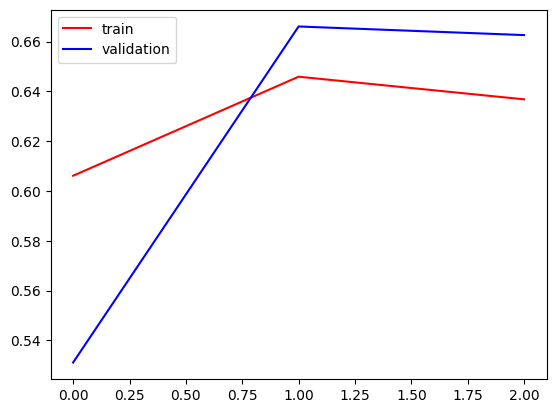

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

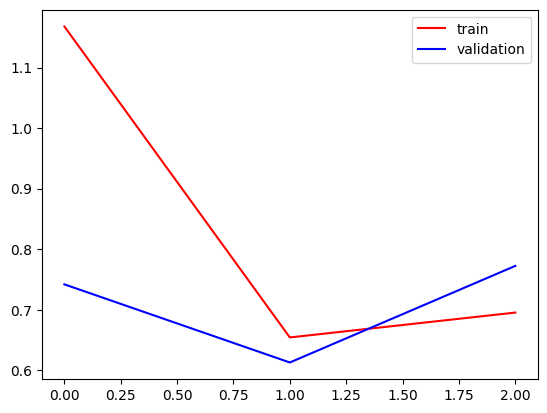

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='binary'
)

Found 1330 images belonging to 2 classes.


In [ ]:
#predict the test data
predictions = resnet_model.predict(test_data)
print(predictions)

42/42 [==============================] - 382s 9s/step
[[0.77663636]
 [0.90438807]
 [0.90141076]
 ...
 [0.9207232 ]
 [0.94420296]
 [0.9553665 ]]


In [ ]:
len(predictions)

1330

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have ground truth labels (true_labels) and predicted labels (predictions)
true_labels = test_data.classes
predicted_labels = (predictions > 0.5).astype(int)  # Adjust the threshold as needed

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

Confusion Matrix:
[[ 18 400]
 [ 40 872]]
Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.04      0.08       418
           1       0.69      0.96      0.80       912

    accuracy                           0.67      1330
   macro avg       0.50      0.50      0.44      1330
weighted avg       0.57      0.67      0.57      1330

